In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, PredictionErrorDisplay
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from textwrap import wrap
from functools import reduce

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model, get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf
from main.components.feature_importance_methods import rename_importnace_col, merge_feature_importances, rank_importances

import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [3]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
218,0,NaN,NaN,NaN,61.0,159.0,24.128792,NaN,NaN,NaN,74.5,0.0,86.0,0.866279,1.0,1.0,0.468553,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,7.22500,4.590000,11.815000,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.71,NaN,NaN,NaN,NaN,122.0,3.15492,0.0,74.0,1.91364,0.0,41.5,1.073190,0.0,29.0,0.32741,0.0,0.560811,0.391892,0.291046,36.088050,5.402265,3.855551,-0.406834,NaN,NaN,NaN,NaN,NaN,77.0,73.0,2.33,13.02,0.442988,31.11,0.443686,0.0,0.0,1.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,34.0
280,1,266.0,72.71,14.495798,45.0,160.0,17.578125,NaN,NaN,NaN,65.0,0.0,70.0,0.928571,1.0,1.0,0.406250,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,6.0,NaN,1.0,NaN,NaN,NaN,0.0,1.0,18.85,17.4700,36.3200,1.0,0.0,0.0,8.50,5.08,2.30,0.57,0.125,0.03,62.7,28.4,7.0,1.5,0.4,3.77,12.0,33.1,2.758333,87.8,31.8,36.3,11.8,0.0,307.0,11.1,10.0,24.7,36.117647,0.032573,133.478261,4.035088,2.208696,0.270588,0.014706,144.0,3.93,9.42,3.94,0.62,0.6,11.0,17.0,0.32,157.0,4.06002,0.0,56.0,1.44816,0.0,89.9,2.324814,0.0,54.0,0.60966,0.0,1.605357,0.964286,0.735650,25.750000,4.267620,4.209900,-0.015794,198.0,109.0,308.0,36.0,100.0,84.0,93.0,3.86,30.11,0.800593,10.49,0.398269,0.0,0.0,4.07,5.80,18.75,12.0,10.0,5.8,7.0,1.206897,444.0,245.0,0.8,0.230548,0.008724,14

### Handle `vitamine D ` outliers

In [3]:
df[VITAMINE_D].mean()

25.551785714285714

In [4]:
df[VITAMINE_D].std()

12.965793597129847

In [5]:
25.5+13+13+13

64.5

In [6]:
df[df[VITAMINE_D] > 64.5][VITAMINE_D]

92      66.0
219     89.0
542     66.0
831     73.0
872     82.0
975    129.0
Name: vitamin 25-OH D ng/ml, dtype: float64

In [4]:
df.loc[df[VITAMINE_D] > 64.5, VITAMINE_D] = np.nan

<Axes: >

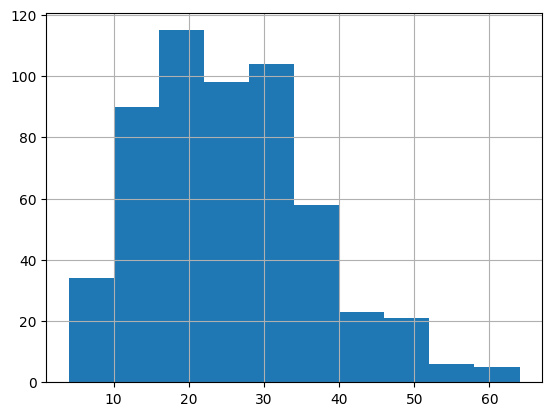

In [5]:
df[VITAMINE_D].hist()

# Model selection for vitamin D

In [6]:
df_vit_d_cleaned = df.dropna(subset=[VITAMINE_D])

X_vit_d, y_vit_d = df_vit_d_cleaned.drop(columns=[VITAMINE_D]), df_vit_d_cleaned[VITAMINE_D]
X_train_vit_d, X_test_vit_d, y_train_vit_d, y_test_vit_d = train_test_split(X_vit_d, y_vit_d, test_size=0.2, random_state=42)

In [10]:
models = [
        # DecisionTreeRegressor(max_depth=7, random_state=42),
        Lasso(),
        # Ridge(),
        RandomForestRegressor(),
        ]

continuous_preprocessings = {
    # 'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    # 'PT_KNN_7': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=7))]),
    'PT_KNN_9': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))]),
    # 'PT_KNN_10': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=10))]),
    # 'RS_iterative_basic': Pipeline([('scaler', RobustScaler()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    # 'RS_KNN': Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))]),
}

categorical_preprocessings = {
    'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    # 'original_ohe_+_impute_knn': Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    # 'original_ohe_+_impute_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
}

scores_df = explore_all_variations_of_preprocessing(X_train_vit_d, y_train_vit_d, VITAMINE_D, models, continuous_preprocessings, categorical_preprocessings)
scores_df

1/12 Lasso() PT_KNN_7 original_ohe_no_imputing [ 0.03096606  0.08848344  0.07994111  0.10626828  0.15468122  0.03919519
  0.01160862  0.17445066  0.02924198  0.12477572  0.1345052   0.13119404
  0.07319376  0.16537963 -0.10643843] 0.08249643179083584
2/12 RandomForestRegressor() PT_KNN_7 original_ohe_no_imputing [-0.08390771  0.04351091  0.04876437  0.15110838  0.15801872 -0.00505112
 -0.05328577  0.18713809  0.07420149  0.12697607  0.19613636  0.13005476
  0.1180487   0.16359798 -0.10755871] 0.07651683568740143
3/12 Lasso() PT_KNN_7 original_ohe_+_impute_knn [ 0.03096606  0.08848344  0.07994111  0.10626828  0.15468122  0.03919519
  0.01160862  0.17445066  0.02924198  0.12477572  0.1345052   0.13119404
  0.07319376  0.16537963 -0.10643843] 0.08249643179083584
4/12 RandomForestRegressor() PT_KNN_7 original_ohe_+_impute_knn [-0.0421505   0.05703483  0.03038859  0.14395116  0.1631126  -0.00396986
 -0.08587541  0.13765438  0.06453558  0.08000079  0.19165846  0.13023263
  0.12284299  0.1087

,continuous_preprocessing,categorical_pteprocessing,model,MAE
0,PT_KNN_7,original_ohe_no_imputing,Lasso(),0.082496
1,PT_KNN_7,original_ohe_no_imputing,RandomForestRegressor(),0.076517
2,PT_KNN_7,original_ohe_+_impute_knn,Lasso(),0.082496
3,PT_KNN_7,original_ohe_+_impute_knn,RandomForestRegressor(),0.065078
4,PT_KNN_9,original_ohe_no_imputing,Lasso(),0.082371
5,PT_KNN_9,original_ohe_no_imputing,RandomForestRegressor(),0.086732
6,PT_KNN_9,original_ohe_+_impute_knn,Lasso(),0.082371
7,PT_KNN_9,original_ohe_+_impute_knn,RandomForestRegressor(),0.077690
8,PT_KNN_10,original_ohe_no_imputing,Lasso(),0.082425
9,PT_KNN_10,original_ohe_no_imputing,RandomForestRegressor(),0.075085


In [21]:
scores_df.groupby(by=['model'])['MAE'].mean()

model
Lasso()                    8.976081
RandomForestRegressor()    8.930126
Name: MAE, dtype: float64

In [22]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    8.883338
                          original_ohe_+_impute_rf     8.899515
                          original_ohe_no_imputing     8.844582
PT_iterative_basic        original_ohe_+_impute_knn    8.901165
                          original_ohe_+_impute_rf     8.914229
                          original_ohe_no_imputing     8.925448
RS_KNN                    original_ohe_+_impute_knn    9.007031
                          original_ohe_+_impute_rf     9.005657
                          original_ohe_no_imputing     8.990216
RS_iterative_basic        original_ohe_+_impute_knn    9.004354
                          original_ohe_+_impute_rf     9.024740
                          original_ohe_no_imputing     9.036970
Name: MAE, dtype: float64

In [11]:
scores_df.groupby(by=['model'])['MAE'].mean()

model
DecisionTreeRegressor(max_depth=7, random_state=42)    11.816821
Lasso()                                                 9.060178
RandomForestRegressor()                                 9.037357
Ridge()                                                11.497512
Name: MAE, dtype: float64

In [7]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    10.206016
                          original_ohe_+_impute_rf     10.142260
                          original_ohe_no_imputing     10.221180
PT_iterative_basic        original_ohe_+_impute_knn    10.169115
                          original_ohe_+_impute_rf     10.208578
                          original_ohe_no_imputing     10.249406
RS_KNN                    original_ohe_+_impute_knn    10.495360
                          original_ohe_+_impute_rf     10.508968
                          original_ohe_no_imputing     10.596368
RS_iterative_basic        original_ohe_+_impute_knn    10.476707
                          original_ohe_+_impute_rf     10.430341
                          original_ohe_no_imputing     10.531306
Name: MAE, dtype: float64

In [8]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    10.106080
                          original_ohe_+_impute_rf     10.134701
                          original_ohe_no_imputing     10.057171
PT_iterative_basic        original_ohe_+_impute_knn    10.101045
                          original_ohe_+_impute_rf     10.086042
                          original_ohe_no_imputing     10.052659
RS_KNN                    original_ohe_+_impute_knn    10.118658
                          original_ohe_+_impute_rf     10.109679
                          original_ohe_no_imputing     10.055548
RS_iterative_basic        original_ohe_+_impute_knn    10.121895
                          original_ohe_+_impute_rf     10.170401
                          original_ohe_no_imputing     10.066486
Name: MAE, dtype: float64

In [9]:
scores_df.groupby(by=['continuous_preprocessing'])['MAE'].mean()

continuous_preprocessing
PT_KNN                10.099317
PT_iterative_basic    10.079915
RS_KNN                10.094628
RS_iterative_basic    10.119594
Name: MAE, dtype: float64

In [10]:
scores_df.groupby(by=['categorical_pteprocessing'])['MAE'].mean()

categorical_pteprocessing
original_ohe_+_impute_knn    10.111920
original_ohe_+_impute_rf     10.125206
original_ohe_no_imputing     10.057966
Name: MAE, dtype: float64

In [11]:
scores_df.groupby(by=['model'])['MAE'].mean()

model
DecisionTreeRegressor(max_depth=7, random_state=42)    11.364120
Lasso()                                                 8.830515
RandomForestRegressor()                                 8.975628
Ridge()                                                11.223191
Name: MAE, dtype: float64

Best preprocessing techniques for vitamine D:
- PT_KNN  + original_ohe_no_imputing

In [7]:
continuous_preprocessor = Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))])
categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])


### Hyperparameter tuning

### Lasso

Fitting 15 folds for each of 9 candidates, totalling 135 fits


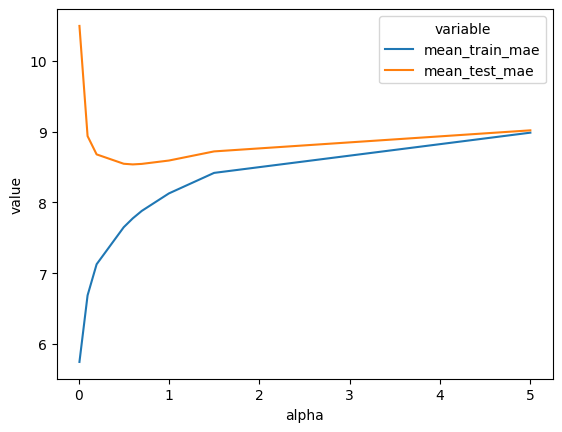

,alpha,mean_train_mae,mean_test_mae
0,0.01,5.746966,10.493781
1,0.1,6.687528,8.937024
2,0.2,7.126772,8.678879
3,0.5,7.649897,8.546469
4,0.6,7.774955,8.537318
5,0.7,7.880766,8.544606
6,1,8.127568,8.592027
7,1.5,8.417539,8.721012
8,5,8.985761,9.018594


In [13]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.01, 0.1, 0.2, 0.5, 0.6, 0.7, 1, 1.5, 5],
    }

vit_d_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Lasso(), continuous_preprocessor, categorical_preprocessor, lasso_param_grid, main_parameter='alpha')
vit_d_lasso_model_hyperparam_tuning_df

Selected alpha: 0.2

### Ridge

Fitting 15 folds for each of 6 candidates, totalling 90 fits


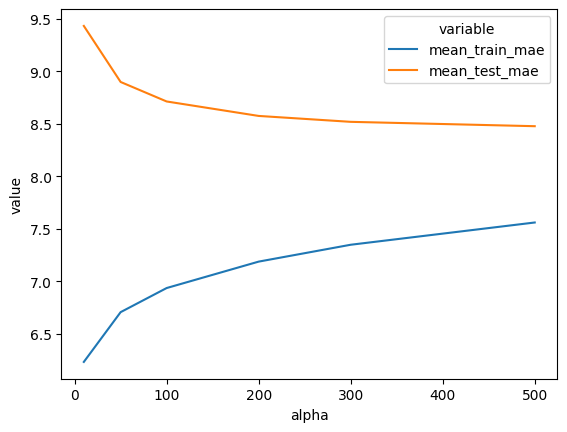

,alpha,mean_train_mae,mean_test_mae
0,10,6.233465,9.432432
1,50,6.707366,8.898773
2,100,6.936897,8.713139
3,200,7.188481,8.575460
4,300,7.349015,8.519250
5,500,7.560861,8.477752


In [23]:
ridge_param_grid = {
    "model__alpha": [10, 50, 100, 200, 300, 500],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_vit_d, y_train_vit_d, VITAMINE_D, Ridge(), continuous_preprocessor, categorical_preprocessor, ridge_param_grid, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

Best alpha: 50 lub 100

### DecisionTreeRegressor

In [35]:
tree_model = DecisionTreeRegressor()

tree_param_grid = {
    "model__criterion": ["absolute_error"],
    "model__max_depth": [8, 9, 10, 12],
    "model__splitter": ["random", "best"],
    "model__min_samples_split": [15, 16, 17, 20],
    "model__min_samples_leaf": [20, 22, 25, 27],
    }

vit_d_tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_vit_d, y_train_vit_d, VITAMINE_D, tree_model, continuous_preprocessor, categorical_preprocessor, tree_param_grid)
vit_d_tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 128 candidates, totalling 1920 fits


,params,mean_train_mae,mean_test_mae
94,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 27, 'model__min_samples_split': 20, 'model__splitter': 'random'}",8.051596,9.153658
114,"{'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 25, 'model__min_samples_split': 16, 'model__splitter': 'random'}",7.931328,9.171357
22,"{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 25, 'model__min_samples_split': 20, 'model__splitter': 'random'}",7.933408,9.227749
16,"{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}",7.942298,9.232884
42,"{'model__criterion': 'absolute_error', 'model__max_depth': 9, 'model__min_samples_leaf': 22, 'model__min_samples_split': 16, 'model__splitter': 'random'}",7.891790,9.258377
18,"{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 25, 'model__min_samples_split': 16, 'model__splitter': 'random'}",8.009245,9.266767
28,"{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17, 'model__splitter': 'random'}",8.021903,9.289721
122,"{'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 27, 'model__min_samples_split': 16, 'model__splitter': 'random'}",8.007836,9.298851
92,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 27, 'model__min_samples_split': 17, 'model__splitter': 'random'}",8.023786,9.300637
112,"{'model__criterion': 'absolute_error', 'model__max_depth': 12, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}",8.011512,9.333725


In [11]:
model = DecisionTreeRegressor(criterion="absolute_error", max_depth=10, min_samples_leaf=27, min_samples_split=15, splitter='random')

tuned_df = compare_random_states(X_train_vit_d, y_train_vit_d, model, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [01:35<00:00,  1.03it/s]


,cv_mae
62,-9.07908
58,-9.187412
14,-9.191769
51,-9.192326
83,-9.193849


### Random Forest

In [42]:
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_features': ['sqrt'],
    'model__max_depth': [None],
    'model__min_samples_split': [3, 5, 7],
    'model__min_samples_leaf': [3, 5, 7],
}

vit_d_rf_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_vit_d, y_train_vit_d, VITAMINE_D, RandomForestRegressor(criterion="absolute_error"), continuous_preprocessor, categorical_preprocessor, param_grid_rf)
vit_d_rf_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 18 candidates, totalling 270 fits


,params,mean_train_mae,mean_test_mae
8,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}",6.047948,8.726923
15,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 200}",6.544893,8.740124
1,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 3, 'model__n_estimators': 200}",5.119564,8.741829
17,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 7, 'model__n_estimators': 200}",6.547260,8.743113
16,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 7, 'model__n_estimators': 100}",6.558310,8.747370
7,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 3, 'model__n_estimators': 200}",6.049708,8.749739
14,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 100}",6.570497,8.753219
13,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 200}",6.547810,8.758884
9,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}",6.038521,8.759326
10,"{'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 7, 'model__n_estimators': 100}",6.066576,8.763497


In [43]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, max_features='sqrt', min_samples_leaf=5, min_samples_split=5, criterion='absolute_error')

tuned_df = compare_random_states(X_train_vit_d, y_train_vit_d, model, VITAMINE_D, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [09:45<00:00,  5.92s/it]


,cv_mae
13,-8.697161
16,-8.713622
7,-8.714204
61,-8.714876
72,-8.717986


## Best models for Vitamine D

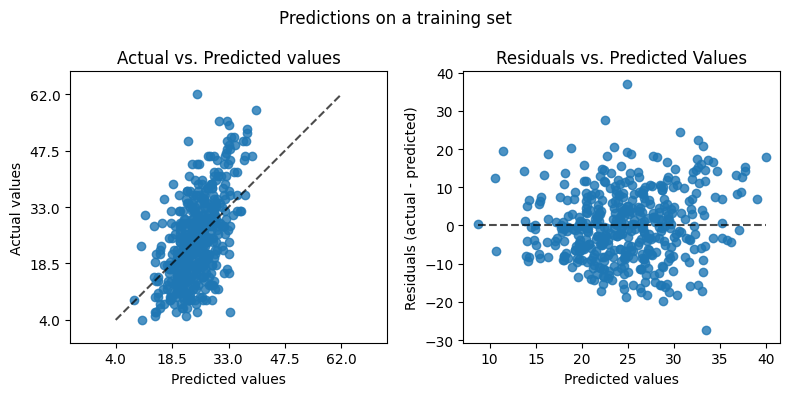

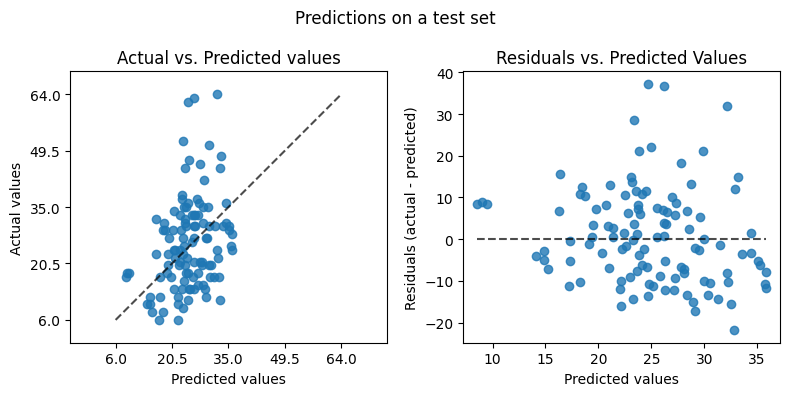

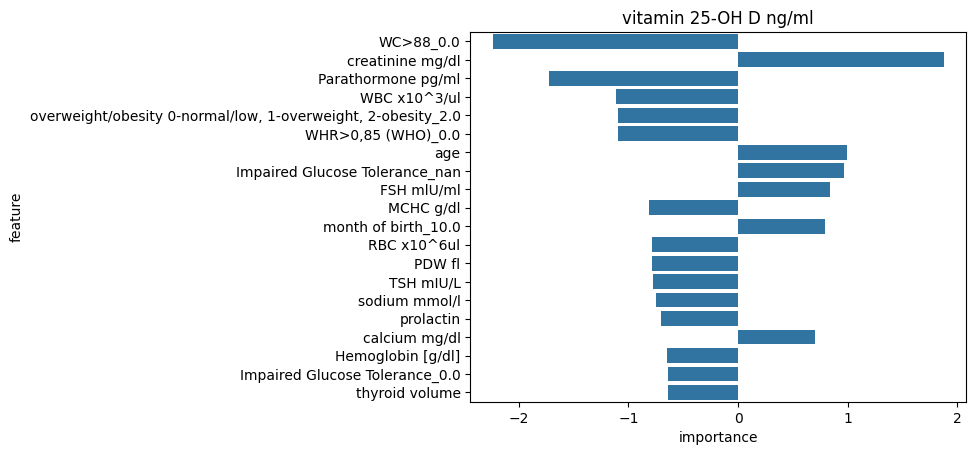

,model,data_set,mse,mae,rmse,r2
0,Lasso(alpha=0.2),training,84.168,7.347,9.174,0.316
1,Lasso(alpha=0.2),test,132.258,9.142,11.500,0.063


In [8]:
lasso_model = Lasso(alpha=0.2)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

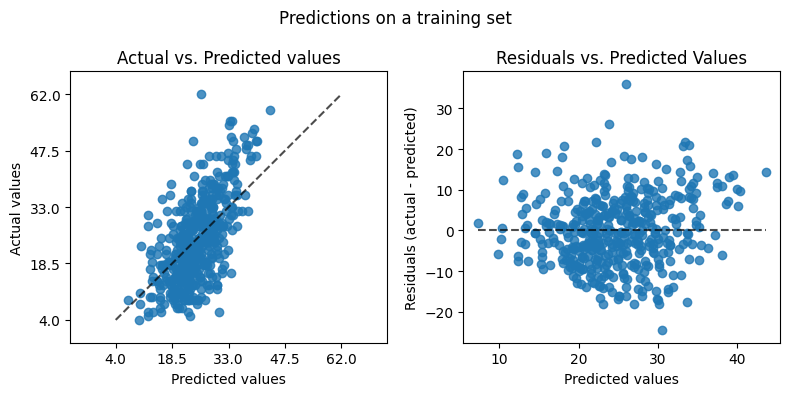

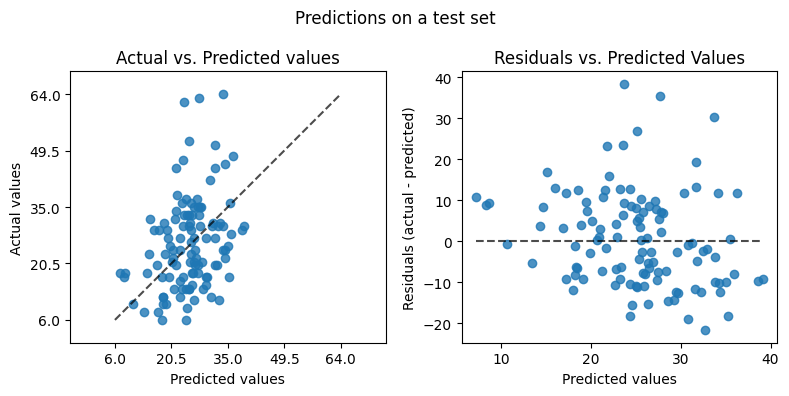

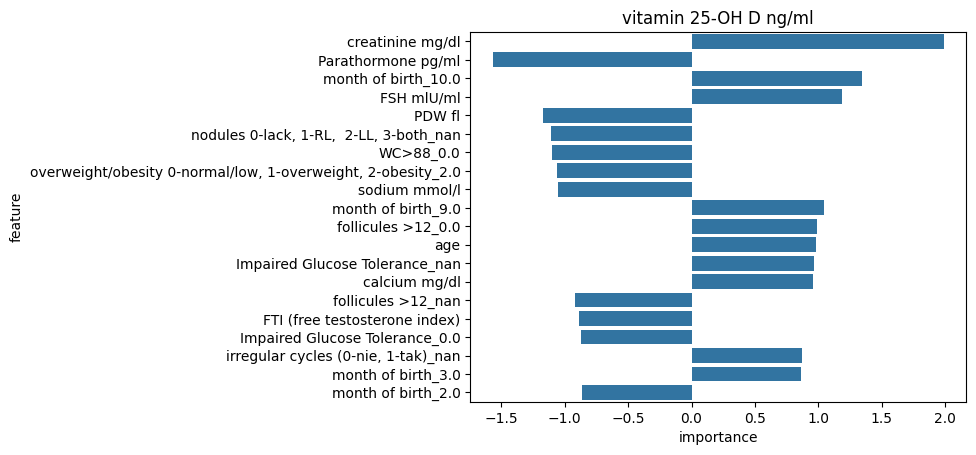

,model,data_set,mse,mae,rmse,r2
0,Ridge(alpha=50),training,74.618,6.930,8.638,0.394
1,Ridge(alpha=50),test,134.662,9.386,11.604,0.046


In [9]:
ridge_model = Ridge(alpha=50)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

In [15]:
feature_importnces_ridge.head(5)

,feature,ridge_importance
54,creatinine mg/dl,1.990129
100,Parathormone pg/ml,-1.568361
206,month of birth_10.0,1.341999
91,FSH mlU/ml,1.183424
40,PDW fl,-1.173251


### Decision Tree

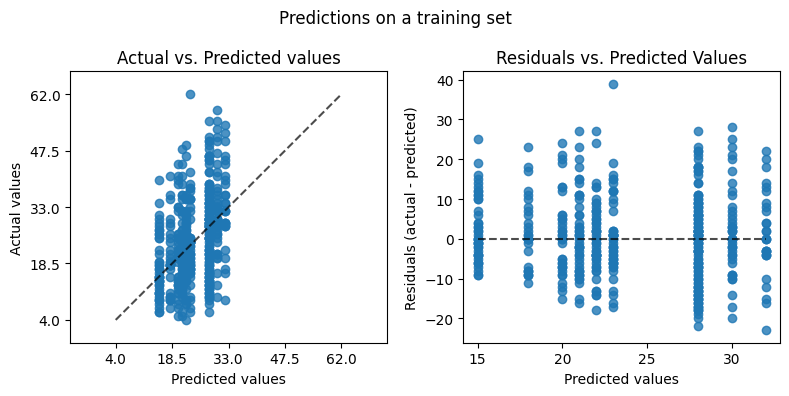

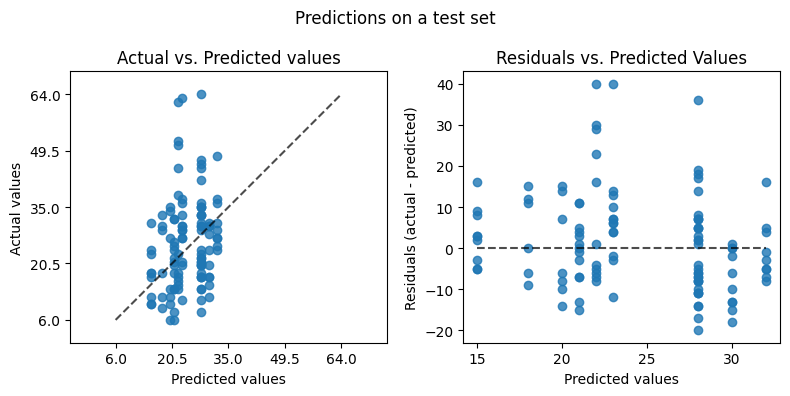

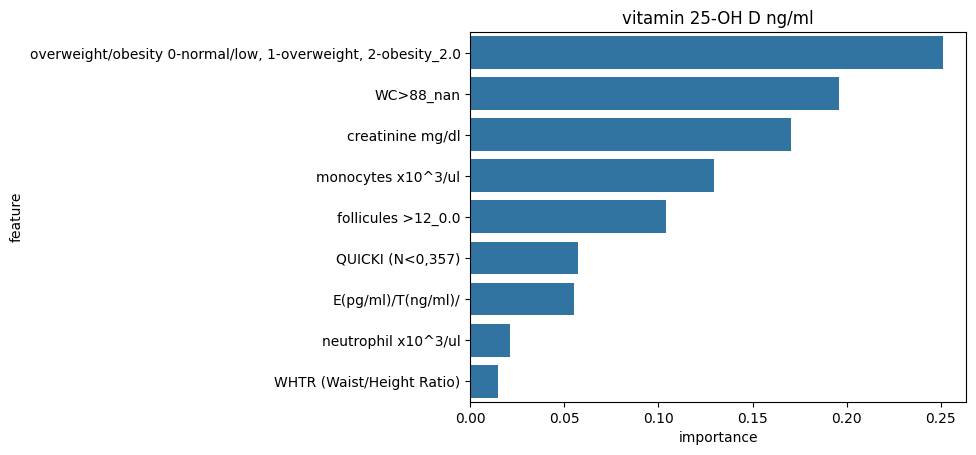

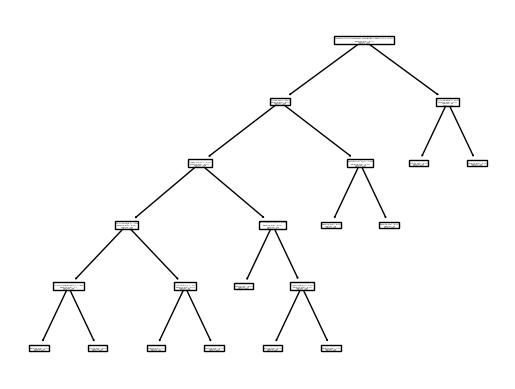

,model,data_set,mse,mae,rmse,r2
0,"DecisionTreeRegressor(criterion='absolute_error', max_depth=10,\n min_samples_leaf=27, min_samples_split=15,\n random_state=62, splitter='random')",training,104.801,7.894,10.237,0.149
1,"DecisionTreeRegressor(criterion='absolute_error', max_depth=10,\n min_samples_leaf=27, min_samples_split=15,\n random_state=62, splitter='random')",test,141.495,9.135,11.895,-0.002


In [16]:
tree_model = DecisionTreeRegressor(criterion="absolute_error", max_depth=10, min_samples_leaf=27, min_samples_split=15, splitter='random', random_state=62)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_tree)
vit_d_model_scores_df

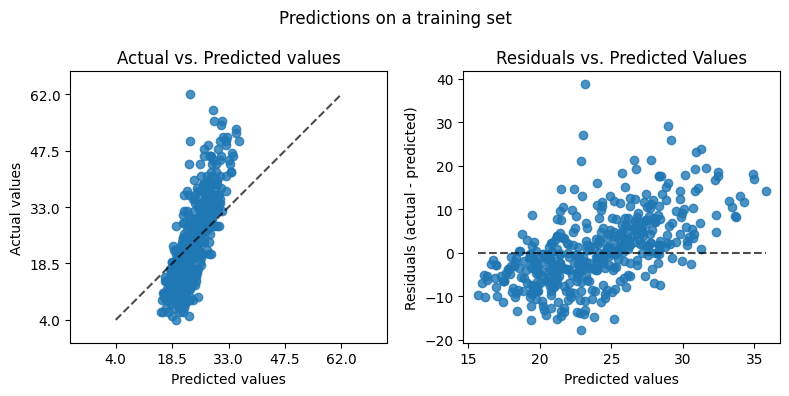

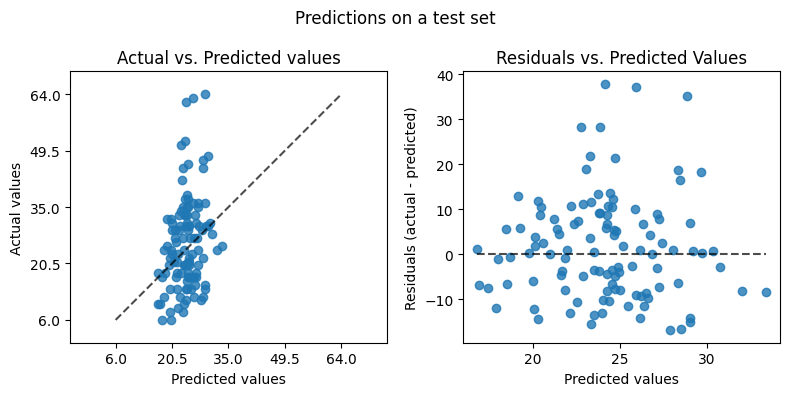

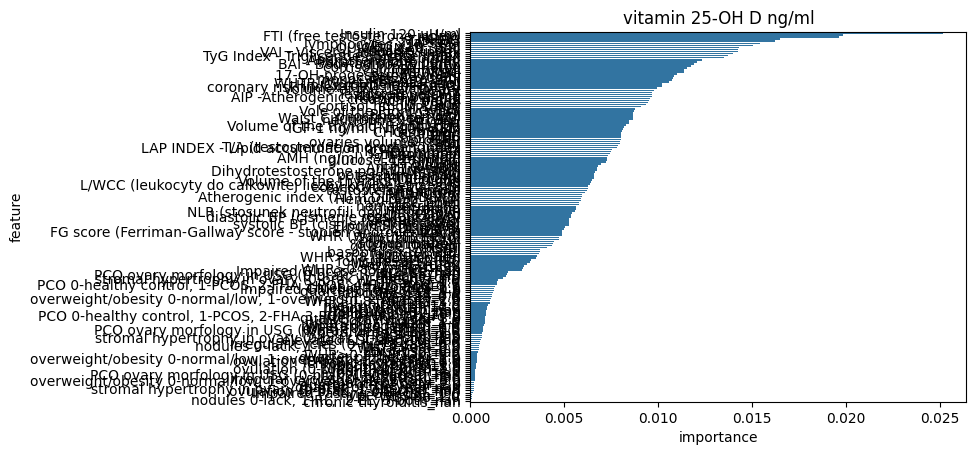

,model,data_set,mse,mae,rmse,r2
0,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=7, min_samples_split=10,\n n_estimators=200, random_state=56)",training,68.703,6.311,8.289,0.442
1,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=7, min_samples_split=10,\n n_estimators=200, random_state=56)",test,133.289,8.929,11.545,0.056


In [17]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=56)
vit_d_model_scores_df, feature_importnces_rf = train_model(rf_model, VITAMINE_D, X_train_vit_d, y_train_vit_d, X_test_vit_d, y_test_vit_d, continuous_preprocessor, categorical_preprocessor, get_feature_importance_rf)
vit_d_model_scores_df

In [18]:
feature_importnces_rf.head(5)

,feature,importance
82,Insulin 120 uU/ml,0.025171
105,FTI (free testosterone index),0.019860
83,HOMA,0.019659
98,T/SHBG,0.016478
84,Matsuda,0.016220


In [19]:
rename_importnace_col(feature_importnces_lasso, 'lasso')
rename_importnace_col(feature_importnces_ridge, 'ridge')
rename_importnace_col(feature_importnces_tree, 'tree')
rename_importnace_col(feature_importnces_rf, 'rf')

feature_importance_df = merge_feature_importances([feature_importnces_lasso, feature_importnces_ridge, feature_importnces_tree, feature_importnces_rf])
feature_importance_df.head(5)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance
0,HDL mg/dl,NaN,-0.046623,NaN,0.006577
1,% lymphocytes,NaN,-0.149272,NaN,0.004417
2,% monocytes,NaN,0.036240,NaN,0.007444
3,% neutrophil,0.503705,0.520125,NaN,0.005617
4,%basophils,NaN,0.026389,NaN,0.003490


In [20]:
ranked_df = rank_importances(feature_importance_df)
ranked_df.head(5)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
0,HDL mg/dl,52.0,195.0,10.0,72.0,82.25
1,% lymphocytes,52.0,157.0,10.0,104.0,80.75
2,% monocytes,52.0,200.0,10.0,60.0,80.50
3,% neutrophil,25.0,60.0,10.0,87.0,45.50
4,%basophils,52.0,205.0,10.0,111.0,94.50


In [21]:
ranked_df.sort_values(by='lasso_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
109,WC>88_0.0,1.0,7.0,10.0,130.0,37.00
136,creatinine mg/dl,2.0,1.0,3.0,33.0,9.75
84,Parathormone pg/ml,3.0,2.0,10.0,15.0,7.50
108,WBC x10^3/ul,4.0,26.0,10.0,7.0,11.75
193,"overweight/obesity 0-normal/low, 1-overweight, 2-obesity_2.0",5.0,8.0,1.0,131.0,36.25
116,"WHR>0,85 (WHO)_0.0",6.0,21.0,10.0,145.0,45.50
127,age,7.0,12.0,10.0,35.0,16.00
52,Impaired Glucose Tolerance_nan,8.0,13.0,10.0,117.0,37.00
30,FSH mlU/ml,9.0,4.0,10.0,64.0,21.75
64,MCHC g/dl,10.0,48.0,10.0,79.0,36.75


In [22]:
ranked_df.sort_values(by='ridge_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
136,creatinine mg/dl,2.0,1.0,3.0,33.0,9.75
84,Parathormone pg/ml,3.0,2.0,10.0,15.0,7.50
172,month of birth_10.0,11.0,3.0,10.0,138.0,40.50
30,FSH mlU/ml,9.0,4.0,10.0,64.0,21.75
80,PDW fl,13.0,5.0,10.0,89.0,29.25
189,"nodules 0-lack, 1-RL, 2-LL, 3-both_nan",52.0,6.0,10.0,180.0,62.00
109,WC>88_0.0,1.0,7.0,10.0,130.0,37.00
193,"overweight/obesity 0-normal/low, 1-overweight, 2-obesity_2.0",5.0,8.0,1.0,131.0,36.25
207,sodium mmol/l,15.0,9.0,10.0,103.0,34.25
182,month of birth_9.0,52.0,10.0,10.0,182.0,63.50


In [23]:
ranked_df.sort_values(by='tree_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
193,"overweight/obesity 0-normal/low, 1-overweight, 2-obesity_2.0",5.0,8.0,1.0,131.0,36.25
111,WC>88_nan,52.0,51.0,2.0,118.0,55.75
136,creatinine mg/dl,2.0,1.0,3.0,33.0,9.75
170,monocytes x10^3/ul,52.0,165.0,4.0,23.0,61.00
145,follicules >12_0.0,45.0,11.0,5.0,112.0,43.25
85,"QUICKI (N<0,357)",33.0,124.0,6.0,8.0,42.75
27,E(pg/ml)/T(ng/ml)/,52.0,160.0,7.0,95.0,78.50
184,neutrophil x10^3/ul,52.0,136.0,8.0,43.0,59.75
119,WHTR (Waist/Height Ratio),52.0,143.0,9.0,25.0,57.25
137,diastolic BP (ciśnienie rozskurczowe),30.0,67.0,10.0,91.0,49.50


In [24]:
ranked_df.sort_values(by='rf_importance').head(10)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
53,Insulin 120 uU/ml,51.0,111.0,10.0,1.0,43.25
33,FTI (free testosterone index),21.0,16.0,10.0,2.0,12.25
38,HOMA,52.0,210.0,10.0,3.0,68.75
91,T/SHBG,52.0,38.0,10.0,4.0,26.00
68,Matsuda,52.0,117.0,10.0,5.0,46.00
169,lymphocytes x10^3/ul,52.0,86.0,10.0,6.0,38.50
108,WBC x10^3/ul,4.0,26.0,10.0,7.0,11.75
85,"QUICKI (N<0,357)",33.0,124.0,6.0,8.0,42.75
164,insulin 0 uU/ml,52.0,201.0,10.0,9.0,68.00
103,VAI - Visceral adiposity index,52.0,106.0,10.0,10.0,44.50


In [26]:
ranked_df.sort_values(by='average_rank').head(15)

,feature,lasso_importance,ridge_importance,tree_importance,rf_importance,average_rank
84,Parathormone pg/ml,3.0,2.0,10.0,15.0,7.50
136,creatinine mg/dl,2.0,1.0,3.0,33.0,9.75
108,WBC x10^3/ul,4.0,26.0,10.0,7.0,11.75
33,FTI (free testosterone index),21.0,16.0,10.0,2.0,12.25
129,calcium mg/dl,17.0,14.0,10.0,19.0,15.00
127,age,7.0,12.0,10.0,35.0,16.00
99,TSH mIU/L,14.0,37.0,10.0,18.0,19.75
30,FSH mlU/ml,9.0,4.0,10.0,64.0,21.75
101,TyG Index - Trigliceride-glucose index,24.0,49.0,10.0,12.0,23.75
91,T/SHBG,52.0,38.0,10.0,4.0,26.00


Most important attributes for `vitamin D`: 'creatinine mg/dl', 'Parathormone pg/ml', 'FTI (free testosterone index)', `WBC x10^3/ul	`, `calcium mg/dl	`, `age`